# Dicionário de dados

ip: endereço de IP do clique

app: id do aplicativo

device: modelo do telefone móvel (iphone 6, iphone 7...)

os: versão do sistema operacional do aparelho móvel

channel: ID do canal do editor de anúncios para celular

clique_time: horário do clique

attributed_time: horário de download do aplicativo após clique em um anúncio

is_attributed: o alvo a ser predito indicando se o aplicativo foi baixado



## Importando bibliotecas 

In [53]:
library(tidyverse)
library(data.table)
library(lubridate)
library(gridExtra)
library(naivebayes)
library(ROSE)
library(randomForest)
library(caret)
library(e1071)
options(warn=-1) #suprimir warnninghs

# Carregando conjunto de dados 

In [3]:
df_raw <- tibble(fread("train_sample.csv"))

df <- copy(df_raw) # criando uma cópia do df original

head(df)

ip,app,device,os,channel,click_time,attributed_time,is_attributed
<int>,<int>,<int>,<int>,<int>,<dttm>,<dttm>,<int>
87540,12,1,13,497,2017-11-07 09:30:38,NA,0
105560,25,1,17,259,2017-11-07 13:40:27,NA,0
101424,12,1,19,212,2017-11-07 18:05:24,NA,0
94584,13,1,13,477,2017-11-07 04:58:08,NA,0
68413,12,1,1,178,2017-11-09 09:00:09,NA,0
93663,3,1,17,115,2017-11-09 01:22:13,NA,0


# Pré-processamento

In [4]:
glimpse(df)

Rows: 99,374
Columns: 8
$ ip              <int> 87540, 105560, 101424, 94584, 68413, 93663, 17059, 121…
$ app             <int> 12, 25, 12, 13, 12, 3, 1, 9, 2, 3, 3, 3, 3, 6, 2, 25, …
$ device          <int> 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, …
$ os              <int> 13, 17, 19, 13, 1, 17, 17, 25, 22, 19, 22, 13, 22, 20,…
$ channel         <int> 497, 259, 212, 477, 178, 115, 135, 442, 364, 135, 489,…
$ click_time      <dttm> 2017-11-07 09:30:38, 2017-11-07 13:40:27, 2017-11-07 …
$ attributed_time <dttm> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ is_attributed   <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …


Todas as variáveis carregadas como int representam na verdade informações categóricas e serão convertidas para o tipo fator.

Além disso, as data e hora dos clicks serão extraidas de click_time e constituirão novas variáveis.

Por fim, os rótulos da variável target (is_attributed) serão ajustados para "N" (download não realizado) e "Y" (download efetuado).

In [8]:
df <- df %>%
mutate (
#criando novas variáveis para dia da semana e hora
Day = weekdays(click_time),
Hour = hour(click_time),
#ajustando rótulos da variável target
is_attributed = ifelse(is_attributed == 0, "N", "Y"),
#convertendo tipos inteiro e string para fator
across( c(where(is.integer), where(is.character)), as.factor  )
)

glimpse(df)

Rows: 99,374
Columns: 10
$ ip              <fct> 87540, 105560, 101424, 94584, 68413, 93663, 17059, 121…
$ app             <fct> 12, 25, 12, 13, 12, 3, 1, 9, 2, 3, 3, 3, 3, 6, 2, 25, …
$ device          <fct> 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, …
$ os              <fct> 13, 17, 19, 13, 1, 17, 17, 25, 22, 19, 22, 13, 22, 20,…
$ channel         <fct> 497, 259, 212, 477, 178, 115, 135, 442, 364, 135, 489,…
$ click_time      <dttm> 2017-11-07 09:30:38, 2017-11-07 13:40:27, 2017-11-07 …
$ attributed_time <dttm> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ is_attributed   <fct> N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, …
$ Day             <fct> terça, terça, terça, terça, quinta, quinta, quinta, te…
$ Hour            <fct> 9, 13, 18, 4, 9, 1, 1, 10, 9, 12, 8, 5, 10, 14, 0, 23,…


Agora as variáveis estão no formato correto.

# Análise exploratória 

In [23]:
#verificando valores missing

data.frame(sapply(df, anyNA))

,sapply.df..anyNA.
,<lgl>
ip,FALSE
app,FALSE
device,FALSE
os,FALSE
channel,FALSE
click_time,FALSE
attributed_time,TRUE
is_attributed,FALSE
Day,FALSE


A única variável com valores missing é attributed_time.

In [25]:
#intervalo de tempo

range(df$click_time)

[1] "2017-11-06 16:00:00 UTC" "2017-11-09 15:59:51 UTC"

clicks foram coletados durante 3 dias.

In [6]:
#verificando dimensões do dataset

dim(df)

[1] 99374     8

In [9]:
#verificando valores únicos para cada variável do dataset

data.frame(sapply(df, n_distinct))

,sapply.df..n_distinct.
,<int>
ip,34737
app,161
device,99
os,130
channel,161
click_time,79956
attributed_time,227
is_attributed,2
Day,4


Nota-se um menor número de IPs únicos (34.737) em relação aos clicks totais (99.374), indicando 
que um mesmo IP realizou mais de um click.

Avaliando graficamente temos que...

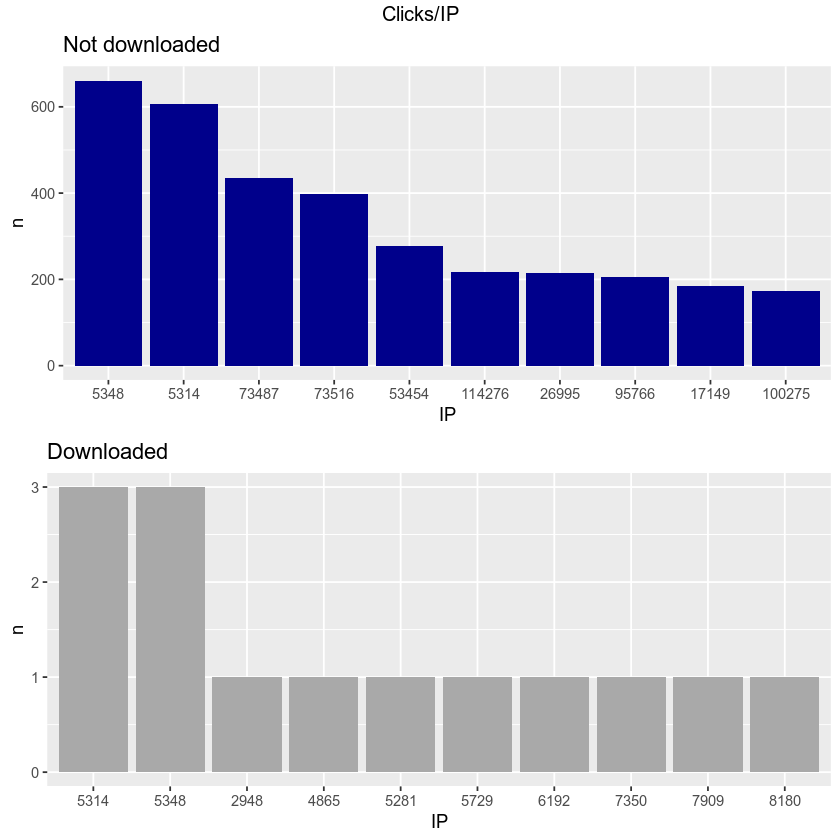

In [10]:
# cliques por IP

p1 <- ggplot(data = df %>% 
         filter(is_attributed == "N") %>%
         group_by(ip) %>%
         summarise(n=n()) %>%
         arrange(desc(n)) %>%
         slice_head(n = 10)) +
  geom_col(aes(x=reorder(ip, desc(n)), y = n), fill = "darkblue") +
  xlab("IP") +
  ggtitle("Not downloaded")

p2 <- ggplot(data = df %>% 
               filter(is_attributed == "Y") %>%
               group_by(ip) %>%
               summarise(n=n()) %>%
               arrange(desc(n)) %>%
               slice_head(n = 10)) +
  geom_col(aes(x=reorder(ip, desc(n)), y = n), fill = "darkgrey") +
  xlab("IP") +
  ggtitle("Downloaded")

grid.arrange(p1,p2, top = "Clicks/IP")

... Apenas 2 IPs (5314 e 5348) realizaram mais que um download.

IPs nas faixas "53" e "73" efetuaram muitos clicks que não resultaram em downloads, levantando suspeitas sobre esses "ranges".

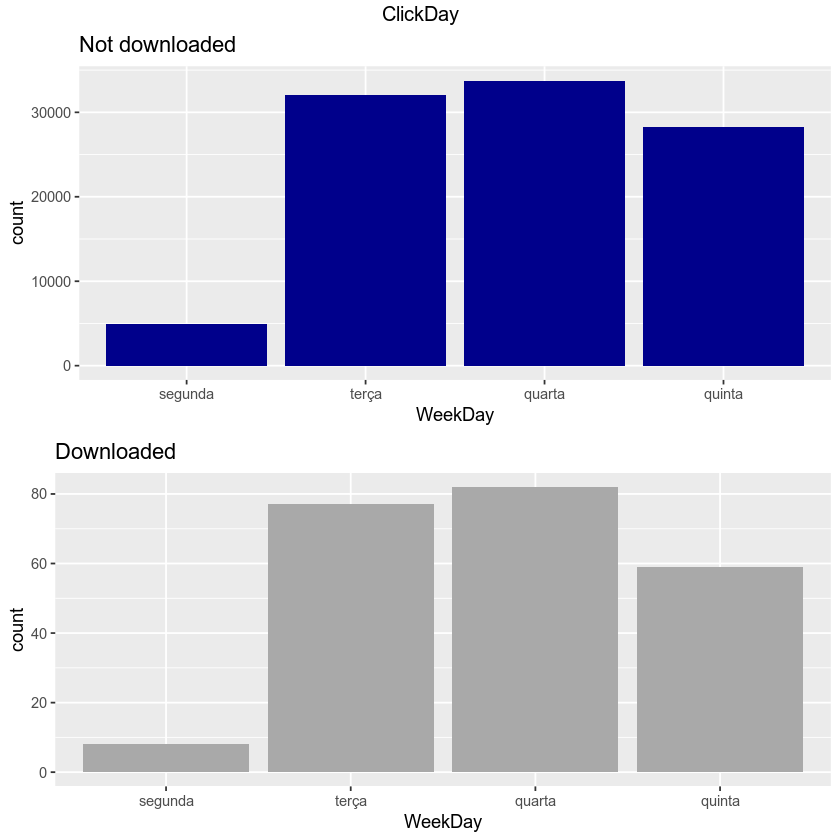

In [11]:
# cliques por dia da semana

p3 <- ggplot(data = filter(df,is_attributed == "N"), mapping = aes(x = factor(Day, levels = c("segunda","terça","quarta","quinta")))) +
  geom_bar(fill = "darkblue") +
  xlab("WeekDay") +
  ggtitle("Not downloaded")

p4 <- ggplot(data = filter(df,is_attributed == "Y"), mapping = aes(x = factor(Day, levels = c("segunda","terça","quarta","quinta")))) +
  geom_bar(fill = "darkgrey") +
  xlab("WeekDay") +
  ggtitle("Downloaded")

grid.arrange(p3,p4, top = "ClickDay")

Segunda Feira foi o dia com menor número de clicks independente se foi efetuado ou não 
o download.

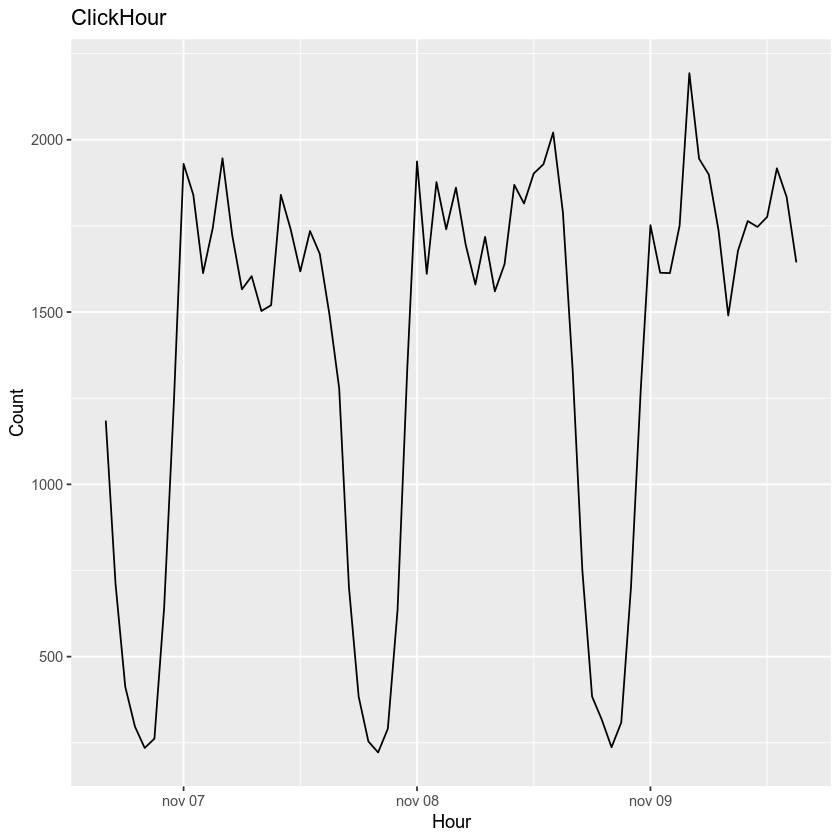

In [16]:
# cliques por hora_1 

df %>%
  mutate(datesTrunc = floor_date(click_time, unit = "hour")) %>%
  group_by(datesTrunc) %>%
  summarise(n = n()) %>%
ggplot(aes(x = datesTrunc, y = n)) +
  geom_line() +
  xlab("Hour") +
  ylab("Count") +
  labs(title = "ClickHour")


Os clicks apresentaram um padrão cíclico ao longo dos três dias 

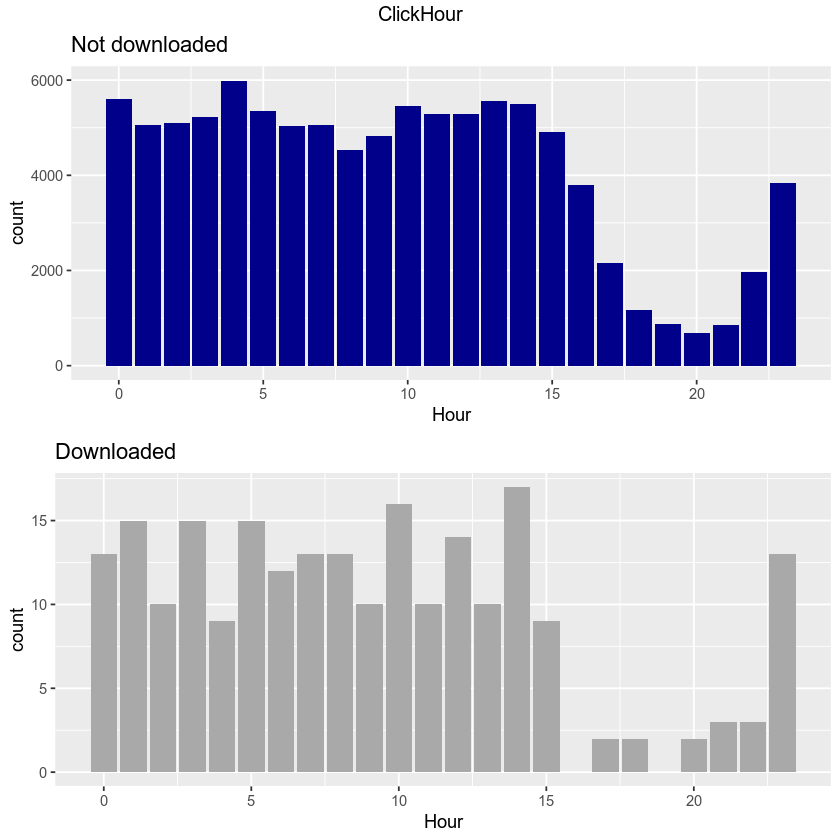

In [19]:
#cliques por hora_2

p5 <- ggplot(data = filter(df, is_attributed == "N"), mapping = aes(x = Hour)) +
  geom_bar(fill = "darkblue") +
  xlab("Hour") +
  ggtitle("Not downloaded")

p6 <- ggplot(data = filter(df, is_attributed == "Y"), mapping = aes(x = Hour)) +
  geom_bar(fill = "darkgrey") +
  xlab("Hour") +
  ggtitle("Downloaded")

grid.arrange(p5,p6, top = "ClickHour")

Houve uma redução de clicks entre as 17 - 22h

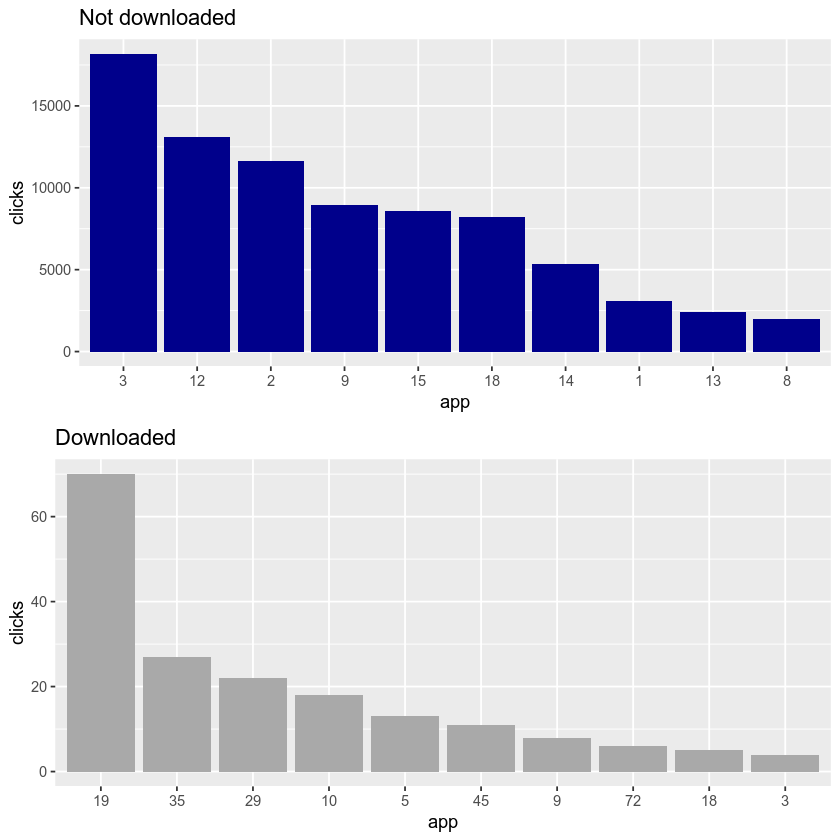

In [17]:
# cliques por app

p7<-df %>%
  filter(is_attributed == "N") %>%
  group_by(app) %>%
  summarise(n=n()) %>%
  arrange(desc(n)) %>%
  slice_head(n = 10) %>%
  ggplot(aes(x = reorder(app, desc(n)), y = n)) +
  geom_col(fill = "darkblue")+
  xlab("app") +
  ylab("clicks") +
  ggtitle("Not downloaded")

p8<-df %>%
  filter(is_attributed == "Y") %>%
  group_by(app) %>%
  summarise(n=n()) %>%
  arrange(desc(n)) %>%
  slice_head(n = 10) %>%
  ggplot(aes(x = reorder(app, desc(n)), y = n)) +
  geom_col(fill = "darkgrey")+
  xlab("app") +
  ylab("clicks") +
  ggtitle("Downloaded")

grid.arrange(p7,p8)

O fato do app3 ser aquele com maior número de clicks sem download (>15.000) e não figurar entre os mais baixados indica que ele é um possível alvo de fraudes. 

O mesmo raciocinio pode ser aplicado ao app9

O app19 foi o mais baixado dentre todos durante o intervalo total de três dias





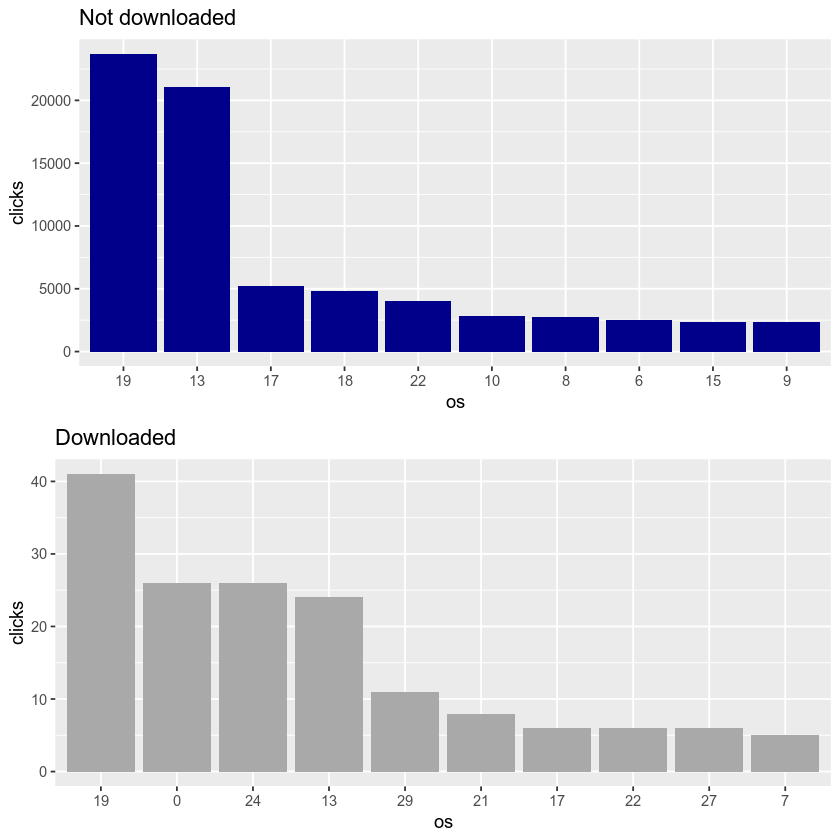

In [18]:
# cliques por SO

p9 <- df %>%
  filter(is_attributed == "N") %>%
  group_by(os) %>%
  summarise(n=n()) %>%
  arrange(desc(n)) %>%
  slice_head(n = 10) %>%
  ggplot(aes(x = reorder(os, desc(n)), y = n)) +
  geom_col(fill = "darkblue") +
  xlab("os") +
  ylab("clicks") +
  ggtitle("Not downloaded")


p10 <- df %>%
  filter(is_attributed == "Y") %>%
  group_by(os) %>%
  summarise(n=n()) %>%
  arrange(desc(n)) %>%
  slice_head(n = 10) %>%
  ggplot(aes(x = reorder(os, desc(n)), y = n)) +
  geom_col(fill = "darkgrey") +
  xlab("os") +
  ylab("clicks") +
  ggtitle("Downloaded")


grid.arrange(p9,p10)

2 SO (19 e 13) possuem maior um elevado número de clicks (talvez android e IOS?) quando comparado com os demais.

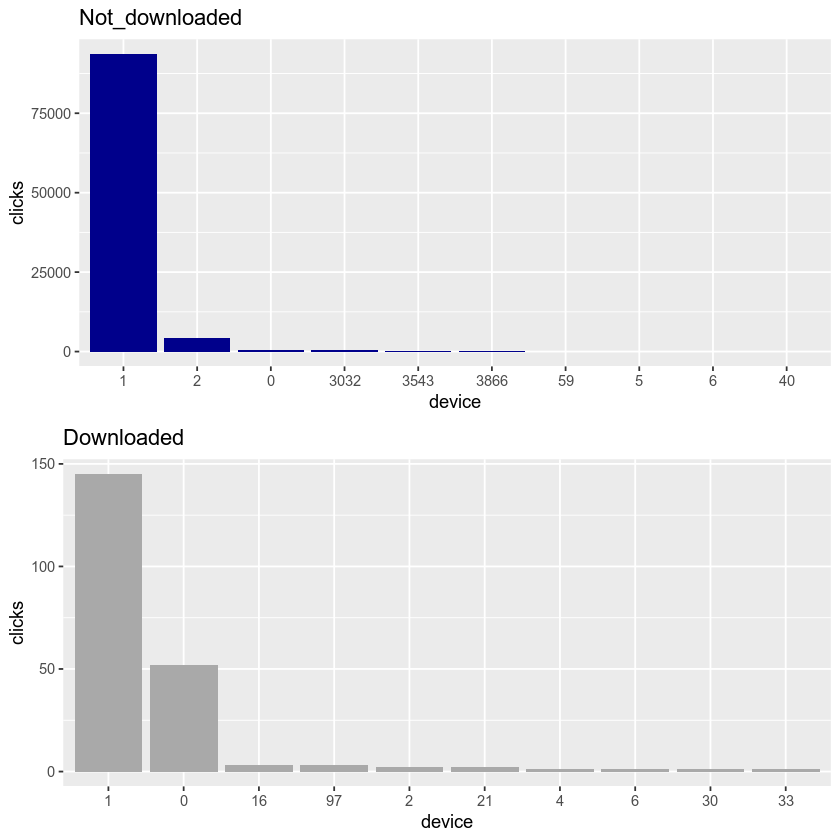

In [22]:
# cliques por device

p11<- df %>%
  filter(is_attributed == "N") %>%
  group_by(device) %>%
  summarise(n=n()) %>%
  arrange(desc(n)) %>%
  slice_head(n = 10) %>%
  ggplot(aes(x = reorder(device, desc(n)), y = n)) +
  geom_col(fill = "darkblue") +
  xlab("device") +
  ylab("clicks") +
  ggtitle("Not_downloaded")


p12<- df %>%
  filter(is_attributed == "Y") %>%
  group_by(device) %>%
  summarise(n=n()) %>%
  arrange(desc(n)) %>%
  slice_head(n = 10) %>%
  ggplot(aes(x = reorder(device, desc(n)), y = n)) +
  geom_col(fill = "darkgrey") +
  xlab("device") +
  ylab("clicks") +
  ggtitle("Downloaded")


grid.arrange(p11,p12)

 O device 1 foi o mais usado para realizar clicks (possivelmente Huawei ou Xiaomi) 

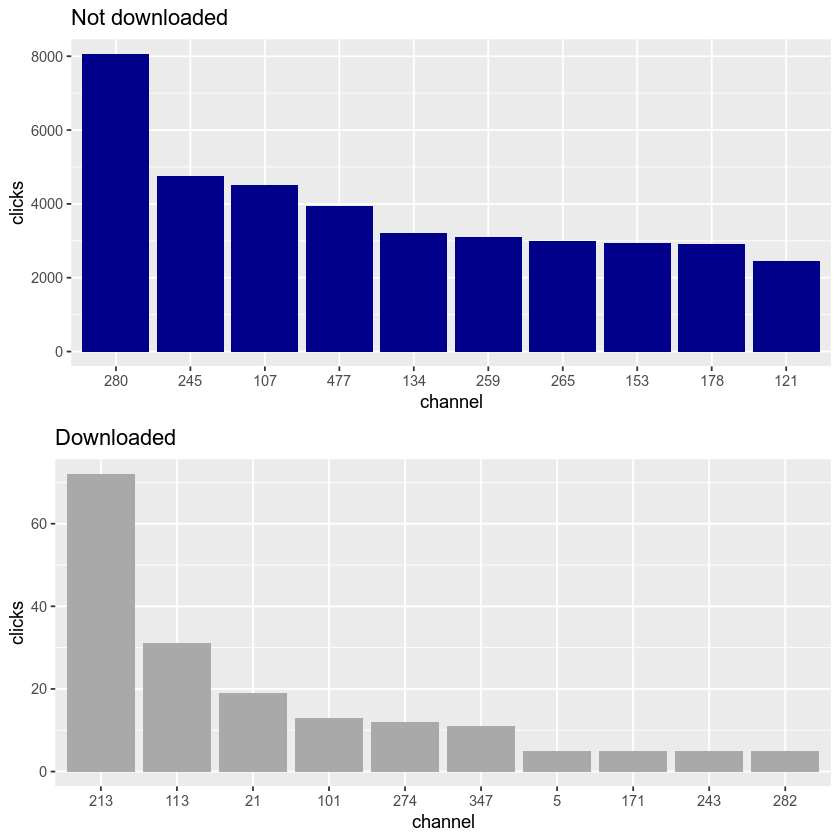

In [26]:
#cliques por canal

p13<- df %>%
  filter(is_attributed == "N") %>%
  group_by(channel) %>%
  summarise(n=n()) %>%
  arrange(desc(n)) %>%
  slice_head(n = 10) %>%
  ggplot(aes(x = reorder(channel, desc(n)), y = n)) +
  geom_col(fill = "darkblue") +
  xlab("channel") +
  ylab("clicks") +
  ggtitle("Not downloaded")

p14<- df %>%
  filter(is_attributed == "Y") %>%
  group_by(channel) %>%
  summarise(n=n()) %>%
  arrange(desc(n)) %>%
  slice_head(n = 10) %>%
  ggplot(aes(x = reorder(channel, desc(n)), y = n)) +
  geom_col(fill = "darkgrey") +
  xlab("channel") +
  ylab("clicks") +
  ggtitle("Downloaded")
grid.arrange(p13,p14)

O canal 280 é suspeito devido ao alto número de clicks sem downloads.

O canal 213 parece não ser usado para fraudes tendo em vista que muitos de seus clicks levaram a downloads.

# Machine Learning

Excluir do dataframe variáveis que não serão utilizadas na etapa de modelagem.

ip representa o identificador de cada clique apresentando muito valores únicos e por isso foi removido

o dia da semana e horario do clique foram extraidos de "click_time", a qual foi removida devido a colinearidade de informações.


is_attributed é uma variável relativa apenas a uma das classes preditoras ("Y") e por isso foi removido da análise. Não faz sentido tentar prever se o download foi realizado ou não com base no horário do download

In [24]:
df <- select(df, -c("ip","click_time","attributed_time"))
head(df)

app,device,os,channel,is_attributed,Day,Hour
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
12,1,13,497,N,terça,9
25,1,17,259,N,terça,13
12,1,19,212,N,terça,18
13,1,13,477,N,terça,4
12,1,1,178,N,quinta,9
3,1,17,115,N,quinta,1


Separando variáveis preditoras e target:

In [25]:
df_predictors <- df[c("app","device","os","channel","Day","Hour")]
df_target <- df[c("is_attributed")]

Convertendo variáveis preditoras em tipo numérico para modelagem:

In [26]:
df_predictors <- tibble(data.frame(sapply(df_predictors, as.integer)))
glimpse(df_predictors)

Rows: 99,374
Columns: 6
$ app     <int> 12, 25, 12, 13, 12, 3, 1, 9, 2, 3, 3, 3, 3, 6, 2, 25, 2, 3, 20…
$ device  <int> 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2,…
$ os      <int> 14, 18, 20, 14, 2, 18, 18, 26, 23, 20, 23, 14, 23, 21, 14, 20,…
$ channel <int> 160, 68, 53, 147, 46, 21, 35, 127, 101, 35, 157, 157, 49, 29, …
$ Day     <int> 4, 4, 4, 4, 2, 2, 2, 4, 1, 1, 1, 4, 2, 1, 4, 1, 2, 2, 3, 3, 2,…
$ Hour    <int> 10, 14, 19, 5, 10, 2, 2, 11, 10, 13, 9, 6, 11, 15, 1, 24, 8, 4…


Ajustando escala das variáveis numéricas:

In [27]:
# definindo função para normalização:
normalizar <- function(x) {
  return ((x - min(x)) / (max(x) - min(x)))
}

#aplicando função nas variáveis preditoras
df_predictors <- data.frame(sapply(df_predictors, normalizar))

Criando novo dataframe unindo as variáveis preditoras normalizadas e a variável target:

In [31]:
df_norm <- cbind(df_predictors,df_target)
glimpse(df_norm)

#Escrevendo dataframe em arquivo csv para posterior carregamento caso necessário
fwrite(df_norm, "df_norm.csv")

#Carregando dataframe normalizado a partir do arquivo csv
#df_norm <- fread("df_norm.csv")
#df_norm$is_attributed <- as.factor(df_norm$is_attributed)

Rows: 99,374
Columns: 7
$ app           <dbl> 0.06875, 0.15000, 0.06875, 0.07500, 0.06875, 0.01250, 0.…
$ device        <dbl> 0.01020408, 0.01020408, 0.01020408, 0.01020408, 0.010204…
$ os            <dbl> 0.100775194, 0.131782946, 0.147286822, 0.100775194, 0.00…
$ channel       <dbl> 0.99375, 0.41875, 0.32500, 0.91250, 0.28125, 0.12500, 0.…
$ Day           <dbl> 1.0000000, 1.0000000, 1.0000000, 1.0000000, 0.3333333, 0…
$ Hour          <dbl> 0.39130435, 0.56521739, 0.78260870, 0.17391304, 0.391304…
$ is_attributed <fct> N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N,…


Dividindo o dataframe em dados de treino (70%) e teste (30%):

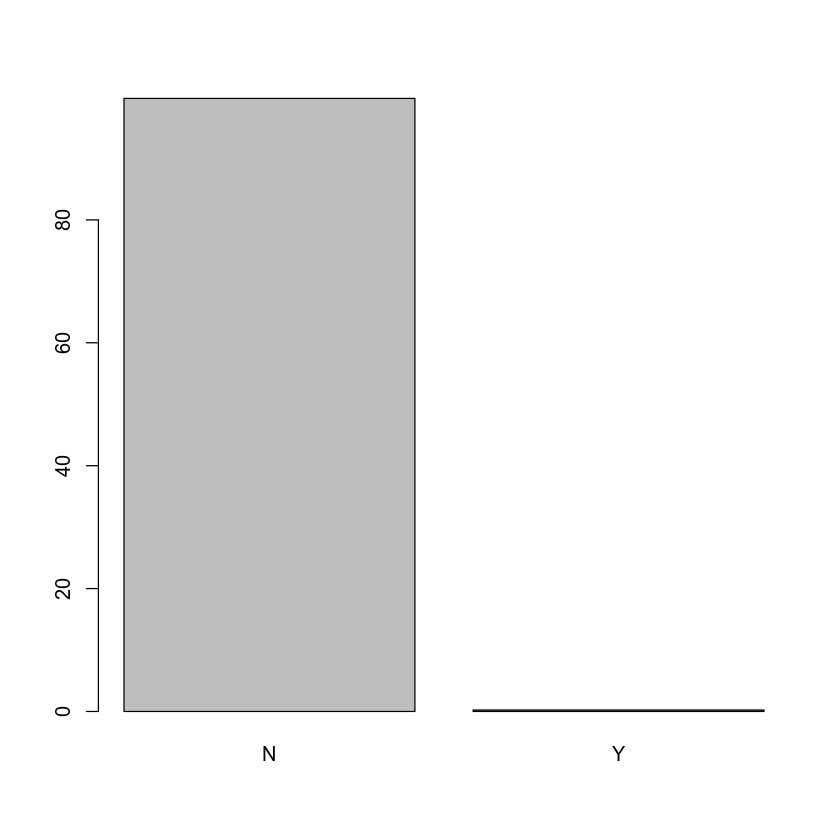

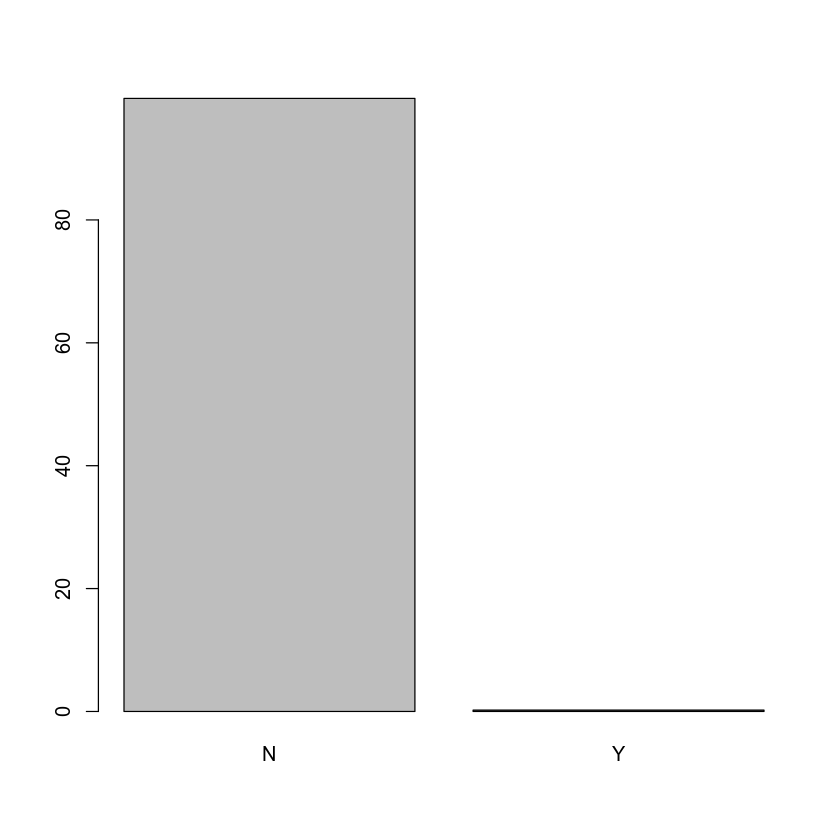

In [33]:
split = createDataPartition(df_norm$is_attributed,p = 0.7, list = F)
treino <- df_norm[split,]
teste <- df_norm[-split,]

plot_treino <- barplot(round(prop.table(table(treino$is_attributed))*100,2))
plot_teste <- barplot(round(prop.table(table(teste$is_attributed))*100,2))

Observa-se que as classes da váriavel target estão desbalanceadas, o que não é ideal 
para modelos de classificação.

Iremos gerar observações sinteticas apartir do método Random Over-Sampling Examples (ROSE)

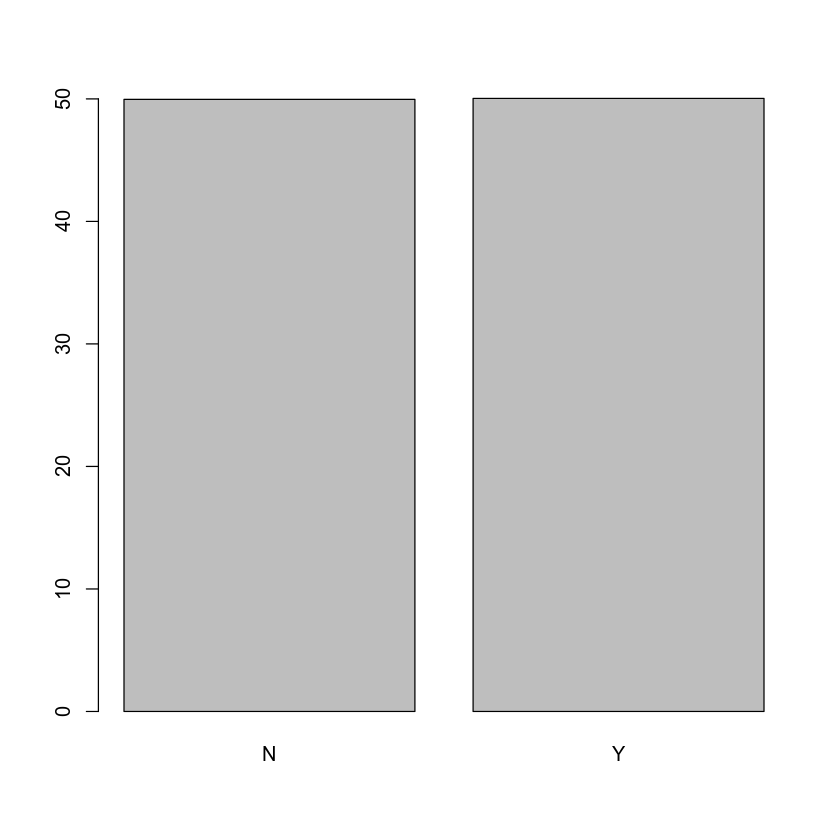

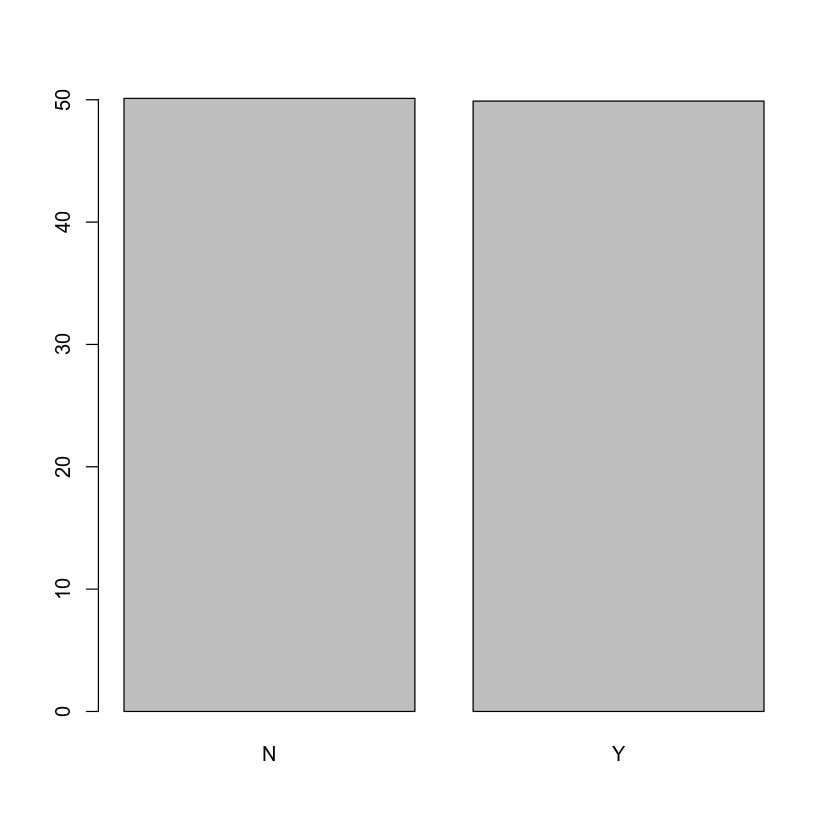

In [34]:
treino_ROSE <- ROSE(is_attributed~., data = treino)$data

teste_ROSE <- ROSE(is_attributed~., data = teste)$data


barplot(round(prop.table(table(treino_ROSE$is_attributed))*100,2))
barplot(round(prop.table(table(teste_ROSE$is_attributed))*100,2))

Agora as classes estão balanceadas e podemos prosseguir para as etapas posteriores.

## Feature Selection

As variáveis com maior importancia para modelagem serão selecionadas com o uso do algoritmo random forest:

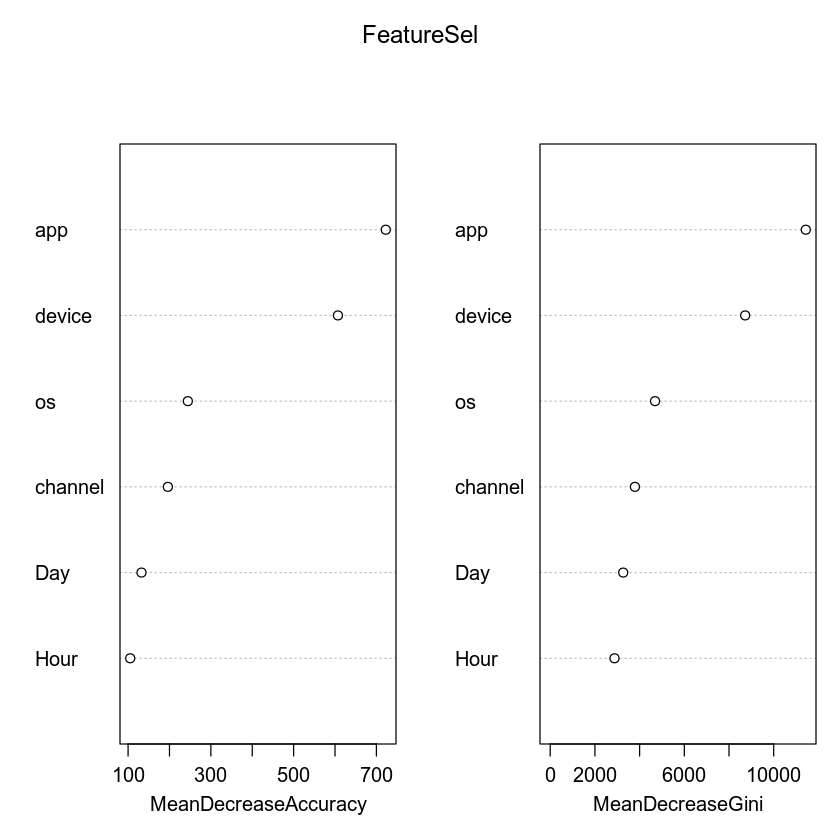

In [35]:
FeatureSel <- randomForest(is_attributed~.,
                      data       = treino_ROSE, 
                      importance = T)
varImpPlot(FeatureSel)

Removendo as variáveis menos importantes (Hour, Day e channel) nos dados de treino e teste.

In [38]:
treino_ROSE_feature_sel <- select(treino_ROSE, -c("Hour","Day","channel"))
teste_ROSE_feature_sel <- select(teste_ROSE, -c("Hour","Day","channel"))
head(treino_ROSE_feature_sel)

,app,device,os,is_attributed
,<dbl>,<dbl>,<dbl>,<fct>
1,-0.009173033,0.076736717,0.1823519,N
2,0.109988856,0.006029960,0.1220796,N
3,0.088078966,0.074373610,0.1264344,N
4,0.001427171,0.008377708,0.1257247,N
5,0.009027798,0.013181944,0.1187692,N
6,0.022785016,0.039131752,0.1668200,N


Serão utilizados três algoritmos para classificação (Regressão Logística, Naive Bayes e Random Forest) sendo selecionado aquele com melhor performance.

In [44]:
#fórmula para o modelo
f <- is_attributed ~ .

#rotulo para treino
rotulo_target <- teste_ROSE_feature_sel$is_attributed

## Regressão Logistica

In [45]:
# treino
modelo1_rl <- train(f, data = treino_ROSE_feature_sel, method = "glm")

# teste
predict1_rl <- predict(modelo1_rl,teste_ROSE_feature_sel)

# avaliação do modelo
confusionMatrix(rotulo_target, predict1_rl, positive = "Y")

Confusion Matrix and Statistics

          Reference
Prediction     N     Y
         N 12117  2822
         Y  4919  9953
                                          
               Accuracy : 0.7403          
                 95% CI : (0.7353, 0.7453)
    No Information Rate : 0.5715          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4805          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.7791          
            Specificity : 0.7113          
         Pos Pred Value : 0.6692          
         Neg Pred Value : 0.8111          
             Prevalence : 0.4285          
         Detection Rate : 0.3339          
   Detection Prevalence : 0.4989          
      Balanced Accuracy : 0.7452          
                                          
       'Positive' Class : Y               
                  

# Naive Bayes

In [54]:
# treino
modelo2_nb <- naiveBayes(f, data = treino_ROSE_feature_sel)

# teste
predict2_nb <- predict(modelo2_nb, teste_ROSE_feature_sel)

# avaliação do modelo
confusionMatrix(rotulo_target, predict2_nb, positive = "Y")

Confusion Matrix and Statistics

          Reference
Prediction     N     Y
         N 14304   635
         Y  4879  9993
                                          
               Accuracy : 0.815           
                 95% CI : (0.8106, 0.8194)
    No Information Rate : 0.6435          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6298          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9403          
            Specificity : 0.7457          
         Pos Pred Value : 0.6719          
         Neg Pred Value : 0.9575          
             Prevalence : 0.3565          
         Detection Rate : 0.3352          
   Detection Prevalence : 0.4989          
      Balanced Accuracy : 0.8430          
                                          
       'Positive' Class : Y               
                  

# Random Forest

In [56]:
# treino
modelo3_rf <- randomForest(f, data = treino_ROSE_feature_sel)

# teste
predict3_rf <- predict(modelo3_rf, teste_ROSE_feature_sel)

# avaliação do modelo
confusionMatrix(rotulo_target, predict3_rf, positive = "Y")

Confusion Matrix and Statistics

          Reference
Prediction     N     Y
         N 12446  2493
         Y  1617 13255
                                         
               Accuracy : 0.8621         
                 95% CI : (0.8582, 0.866)
    No Information Rate : 0.5283         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.7243         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.8417         
            Specificity : 0.8850         
         Pos Pred Value : 0.8913         
         Neg Pred Value : 0.8331         
             Prevalence : 0.5283         
         Detection Rate : 0.4446         
   Detection Prevalence : 0.4989         
      Balanced Accuracy : 0.8634         
                                         
       'Positive' Class : Y              
                                      

# Comparado os modelos

In [57]:
previsoes <- data.frame(observado = rotulo_target,
                        logistic_regression = predict1_rl,
                        naive_bayes = predict2_nb,
                        random_forest = predict3_rf)
head(previsoes)

#exportando previsões para arquivo csv
fwrite(previsoes, "previsoes.csv")

,observado,logistic_regression,naive_bayes,random_forest
,<fct>,<fct>,<fct>,<fct>
1,N,N,N,Y
2,N,N,N,N
3,N,N,N,N
4,N,Y,N,N
5,N,N,N,N
6,N,N,N,N


In [48]:
Modelo <- c("Regressão Logistíca", "Naive Bayes", "Random Forest")
Acuracia <- c(74, 81.5, 86.3)
Sensitividade <- c(77.9, 94, 84.2)
Especificidade <- c(71.1, 74.5, 88.58)

data.frame(Acuracia, Sensitividade, Especificidade, row.names = Modelo)

,Acuracia,Sensitividade,Especificidade
,<dbl>,<dbl>,<dbl>
Regressão Logistíca,74.0,77.9,71.10
Naive Bayes,81.5,94.0,74.50
Random Forest,86.3,84.2,88.58


# Considerações Finais

Afim de reduzir os cliques fraudulentos, algumas medidas podem ser tomadas com base nos dados disponibilizados:

Bloquear ou restringir acesso dos endereços de IPs próximos aqueles com inicio 53 e 73 (apenas caso o IP real tenha alguma relação com a codificação);

Bloquear ou limitar acesso ao canal 280;

Aumentar fiscalização para os app3 e app19;

Aumentar fiscalização nos horários de 0:00 a 15;

Por fim, o modelo para predição de download que apresentou melhor performance nos dados foi o Random Forest.